In [48]:
import dill as pickle
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sim_path = os.path.abspath('simulation')
data_path = os.path.abspath('new_data')

sys.path.append(sim_path)


def load_scheduler(policy='SRSF', trace='0e4a51'):
    fname = os.path.join(data_path, f'{policy}_{trace}_result_scheduler.pkl')
    with open(fname, 'rb') as fp:
        scheduler = pickle.load(fp)
    return scheduler

In [53]:
schedulers = {}
policies = ['SRSF', 'AFS', 'PCS_jct', 'PCS_bal', 'PCS_pred']
for policy in policies:
    scheduler = load_scheduler(policy=policy)
    
    num_attempts_t = {
        0: [],
        1: [],
        10: [],
        40: [],
        60: [],
        100: [],
    }
    
    for app_id, app in scheduler._app_list.items():
        # submit_time = (app.submit_time - scheduler._init_time).total_seconds()
        # start_time = (app.start_time - scheduler._init_time).total_seconds()
        # end_time = (app.end_time - scheduler._init_time).total_seconds()
    
    
        num_apps_seen_diff = app.num_apps_seen[0]/app.num_apps_seen[1]
    
        divided_cluster_size = scheduler._max_capacity/num_apps_seen_diff
        fair_act = app.service/min(divided_cluster_size, app.initial_demand)
    
        if len(app.estimated_start_time) == 0:            
            continue
    
        app.jct = (app.end_time - app.submit_time).total_seconds()
        app.predjcts = [(estimated_end_time - app.submit_time).total_seconds() for estimated_end_time in app.estimated_end_time]
        fracX = []
        for tick in app.jctpred_ticks:
            fracX.append(100.0*(tick - app.submit_time).total_seconds()/app.jct)    
        
        app.errors = np.array([100.0*abs(app.jct - predjct)/predjct for predjct in app.predjcts])
        assert(len(fracX) == len(app.errors))
        
        for t in num_attempts_t:
            index = np.where(app.errors <= t)[0][0]
            num_attempts_t[t].append(fracX[index])
    scheduler.num_attempts_t = num_attempts_t
    schedulers[policy] = scheduler

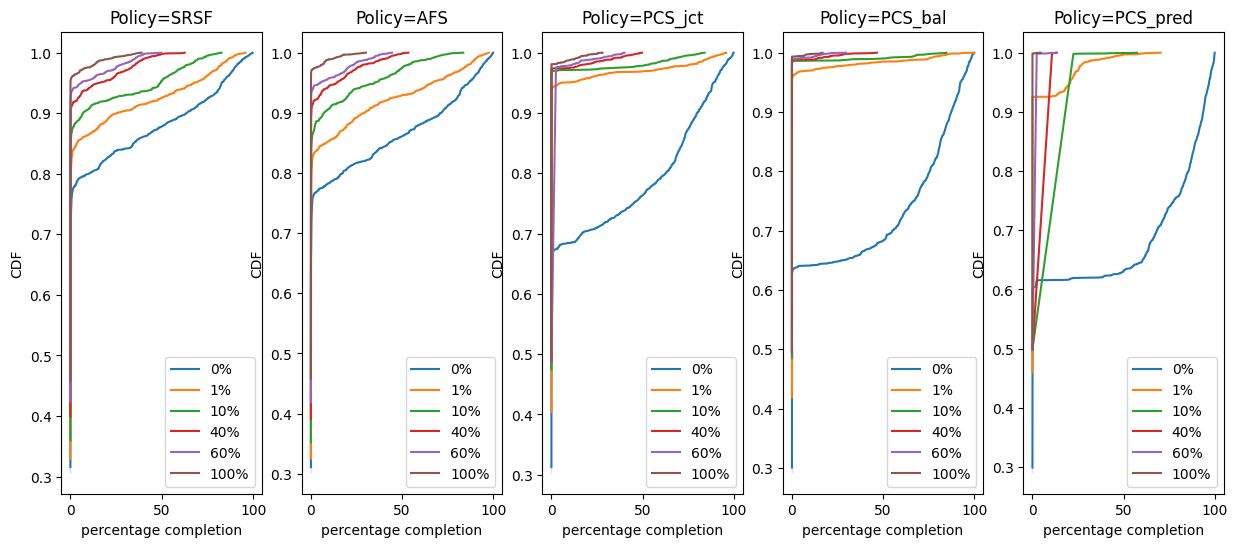

In [54]:
# Initialize the figure with subplots
fig, axs = plt.subplots(1, len(policies), figsize=(15, 6))

for p, policy in enumerate(policies):
    for t in [0,1,10,40,60,100]:
        X = pd.Series(schedulers[policy].num_attempts_t[t])
        X = X.sort_values()
        cdf = np.linspace(0,1,len(X))
        
        sns.lineplot(x=X,y=cdf, label=f'{t}%', ax=axs[p])
    axs[p].set_title(f'Policy={policy}')
    axs[p].set_xlabel('percentage completion')
    axs[p].set_ylabel('CDF')
